# Convolutional Neural Network VGG-16

In [1]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


os.environ["CUDA_VISIBLE_DEVICES"]="0"

base_dir = 'uta_dataset/vgg16images'
drowsy_dir = os.path.join(base_dir, 'DrowsyVGG')
alert_dir = os.path.join(base_dir, 'AlertVGG')

# Creating the definition for dataset split.
def create_splits(data_dir, output_dir, split_ratio=(0.7, 0.10, 0.20)):
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    for category in ['DrowsyVGG', 'AlertVGG']:
        category_dir = os.path.join(data_dir, category)
        images = os.listdir(category_dir)
        train_imgs, test_imgs = train_test_split(images, test_size=split_ratio[1] + split_ratio[2], random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)
        
        for dset, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            output_dset_dir = os.path.join(output_dir, dset, category)
            os.makedirs(output_dset_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(category_dir, img), output_dset_dir)

# Splitting the dataset.
create_splits(base_dir, 'splitted_dataset')

train_dir = os.path.join('splitted_dataset', 'train')
val_dir = os.path.join('splitted_dataset', 'val')
test_dir = os.path.join('splitted_dataset', 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)


2024-02-28 22:51:42.661889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Found 7092 images belonging to 2 classes.
Found 1013 images belonging to 2 classes.
Found 2029 images belonging to 2 classes.


In [2]:
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',name="output")
])


model.compile(optimizer=optimizers.Adamax(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks.
callbacks = [
    ModelCheckpoint('vgg16_fulldefined_drowsiness_detection.h5', save_best_only=True, monitor='val_accuracy',mode="max")
]

# Train the model.
history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,  
    callbacks=callbacks
)


2024-02-28 22:51:45.261823: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-28 22:51:45.262775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-28 22:51:45.476846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2024-02-28 22:51:45.476879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-28 22:51:45.480028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-28 22:51:45.480099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-0

Epoch 1/50


2024-02-28 22:51:47.608569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-28 22:51:48.555324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-02-28 22:51:48.560471: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-02-28 22:51:52.361532: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 15s 84ms/step - loss: 0.6929 - accuracy: 0.5045 - val_loss: 0.6897 - val_accuracy: 0.5270
Epoch 2/50
100/100 [==============================] - 8s 80ms/step - loss: 0.6865 - accuracy: 0.5495 - val_loss: 0.6759 - val_accuracy: 0.5360
Epoch 3/50
100/100 [==============================] - 8s 81ms/step - loss: 0.6321 - accuracy: 0.6386 - val_loss: 0.4735 - val_accuracy: 0.7720
Epoch 4/50
100/100 [==============================] - 8s 80ms/step - loss: 0.4711 - accuracy: 0.7793 - val_loss: 0.3743 - val_accuracy: 0.8300
Epoch 5/50
100/100 [==============================] - 8s 80ms/step - loss: 0.3238 - accuracy: 0.8805 - val_loss: 0.2300 - val_accuracy: 0.9150
Epoch 6/50
100/100 [==============================] - 9s 93ms/step - loss: 0.2306 - accuracy: 0.9132 - val_loss: 0.2140 - val_accuracy: 0.9130
Epoch 7/50
100/100 [==============================] - 8s 80ms/step - loss: 0.2099 - accuracy: 0.9326 - val_loss: 0.1025 - val_accuracy: 0.9660
Epoch 8/5

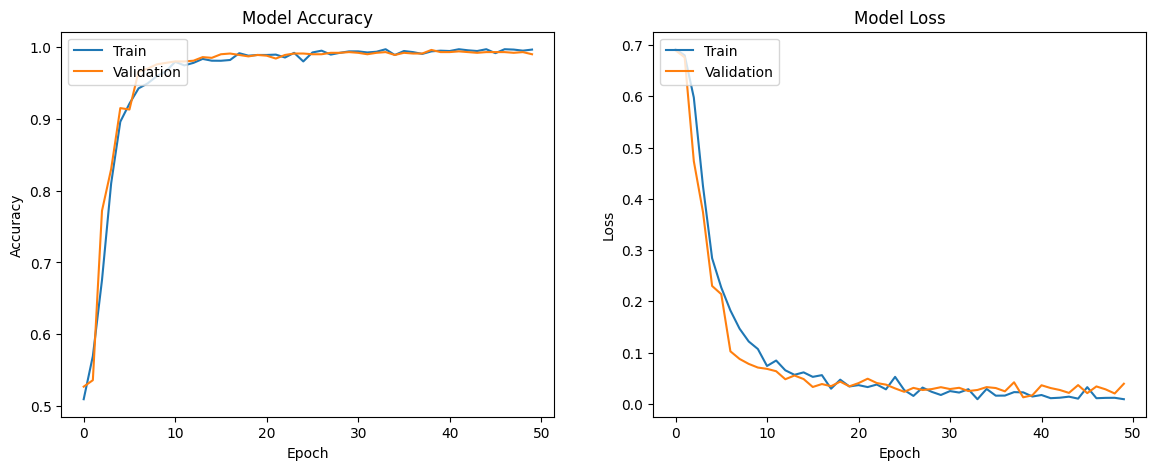

In [3]:
# Plot training & validation accuracy values.
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


50/50 [==============================] - 1s 29ms/step - loss: 0.0431 - accuracy: 0.9920
Test accuracy: 0.9919999837875366
F1 Score: 0.9901185770750988


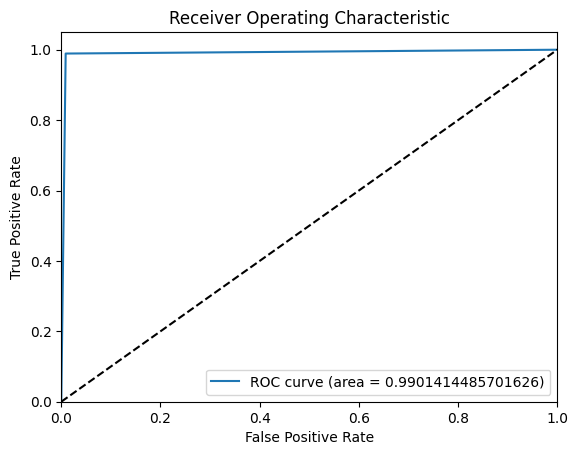

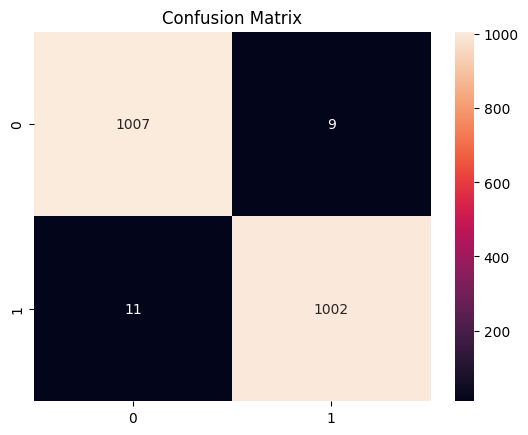

Sensitivity: 0.9911417322834646
Specificity: 0.9891411648568608


In [4]:
# Evaluate the model on the test set.
test_loss, test_acc = model.evaluate(test_generator, steps=50)  # Adjust steps accordingly
print(f"Test accuracy: {test_acc}")

# Predictions for ROC and F1.
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

# ROC Curve.
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for Sensitivity and Specificity.
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity.
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


In [5]:
# Carbon Tracker.

import gc
from carbontracker.tracker import CarbonTracker

tracker = CarbonTracker(epochs=50)
tracker.epoch_start()

history_tracker= model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=1,
    validation_data=validation_generator,
    validation_steps=50,  
)

tracker.epoch_end()
tracker.stop()
gc.collect()

CarbonTracker: The following components were found: GPU with device(s) NVIDIA RTX A6000. CPU with device(s) cpu:1, cpu:0.
100/100 [==============================] - 8s 81ms/step - loss: 0.0129 - accuracy: 0.9955 - val_loss: 0.0259 - val_accuracy: 0.9920
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:08
	Energy:	0.001228 kWh
	CO2eq:	0.131349 g
	This is equivalent to:
	0.001091 km travelled by car
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:06:55
	Energy:	0.061378 kWh
	CO2eq:	6.720909 g
	This is equivalent to:
	0.055822 km travelled by car
CarbonTracker: Finished monitoring.


14828

In [6]:
print(train_generator.class_indices)

{'AlertVGG': 0, 'DrowsyVGG': 1}
